<div class="alert alert-danger" role="alert">
    <span style="font-size:20px">&#9888;</span> <span style="font-size:16px">This is a read-only notebook! If you want to make and save changes, save a copy by clicking on <b>File</b> &#8594; <b>Save a copy</b>. If this is already a copy, you can delete this cell.</span>
</div>

<h1>Standalone Testing<span class="tocSkip"></span></h1> 

This notebook allows you to gain statistical test results on a single model
This notebook relies on re-usable functions, which you can modify or extend as you see fit.

<h2>Table of Contents<span class="tocSkip"></span></h2>

<ul class="toc-item"><li><span><a href="#Import-key-libraries" data-toc-modified-id="Import-key-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import key libraries</a></span></li><li><span><a href="#Select-data" data-toc-modified-id="Select-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Select data</a></span><ul class="toc-item"><li><span><a href="#Specify-file-containing-data" data-toc-modified-id="Specify-file-containing-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Specify file containing data</a></span></li><li><span><a href="#Load-in-the-historical-data" data-toc-modified-id="Load-in-the-historical-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load in the historical data</a></span></li></ul></li><li><span><a href="#Define-model-variables-and-run-statistical-tests" data-toc-modified-id="Define-model-variables-and-run-statistical-tests-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define model variables and run statistical tests</a></span><ul class="toc-item"><li><span><a href="#Specify-the-output-file-for-the-results-associated-with-this-model" data-toc-modified-id="Specify-the-output-file-for-the-results-associated-with-this-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Specify the output file for the results associated with this model</a></span></li><li><span><a href="#Specify-the-dependent-variable-and-independent-variables" data-toc-modified-id="Specify-the-dependent-variable-and-independent-variables-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Specify the dependent variable and independent variables</a></span></li><li><span><a href="#Run-model-testing" data-toc-modified-id="Run-model-testing-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Run model testing</a></span></li></ul></li><li><span><a href="#Forecast-under-different-scenarios" data-toc-modified-id="Forecast-under-different-scenarios-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Forecast under different scenarios</a></span><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Run-Forecast" data-toc-modified-id="Run-Forecast-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Run Forecast</a></span></li><li><span><a href="#Save-results-into-Excel-file" data-toc-modified-id="Save-results-into-Excel-file-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Save results into Excel file</a></span></li></ul></li></ul>

# Import key libraries

In [1]:
# Import key libraries
import shutil 
import os
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels
from datetime import datetime
from openpyxl import load_workbook

%load_ext autoreload
%autoreload 2

**Import code stored in the utilities folder**

In [2]:
import sys
sys.path.insert(0, "../../utilities")
from data_transformations import timeseries_transforms
from regression import deepdive_ols as standalone
from regression import stats_utilities

# Select data

## Specify file containing data

This should be an Excel file containing historical data (transformed data ideally), and scenario data. If any transformations are necessary, the variable mapping table is also needed. If you do not have a variable mapping table, use the code from Section 4 in the "[template] statsmodels Timeseries Regression Model Development" notebook.

If you are running this code after having used the model development notebook, this path could simply be the output (or input) Excel used by the model development notebook.

It is recommended that you use the following data format in the Excel:
* Quarterly, e.g. 2004Q1, 2004Q2
* Annual, e.g. 2004, 2005
* Monthly, e.g. 2004-1, 2004-2, 2004-3

If you do not use this format in the column, you may need to modify the code in Section 2.2 and the standalone.forecast function to transform the column appropriately

In [5]:
# input_path = 'sample_output/session_file_0112 Test.xlsx'
input_path = "sample_input/ts_model_data.xlsx"

data_frequency = 4    # 1 for annual, 4 for quarterly, and 12 for monthly data
date_column = 'date_quarter' # Column in untransformed data containing the date

## Load in the historical data

In [6]:
wb = load_workbook(filename=input_path, read_only=True)    
sheetnames = list(wb.sheetnames)
wb.close()

if 'transformed_dataset' in sheetnames:
    print("Reading in transformed historical data")
    transformed_data = pd.read_excel(input_path, sheet_name='transformed_dataset')
    transformed_data = transformed_data.set_index('date')
    transformed_data.index = pd.to_datetime(transformed_data.index)
    
else:
    print("Transform the input data")
    # Read in the historical data
    dataset = pd.read_excel(input_path, sheet_name='input_dataset')
    
    # Create a timeseries index
    if data_frequency == 4:
        dataset.index = pd.PeriodIndex(dataset[date_column], freq='Q').to_timestamp()
    elif data_frequency == 1:
        dataset.index = pd.PeriodIndex(dataset[date_column], freq='Y').to_timestamp()
    elif data_frequency == 12:
        dataset.index = pd.PeriodIndex(dataset[date_column], freq='M').to_timestamp()
    else:
        raise ValueError("data_frequency must be 1, 4 or 12")
        
    dataset.index.name = 'date'
    # Sort the dataset in descending order of date
    dataset = dataset.sort_values(by='date', ascending=True)
    
    # Read in transformations
    transformations_input = pd.read_excel(input_path, sheet_name='variable_mapping_table')
    dataset_transformed = timeseries_transforms.run_transforms(ts_data=dataset, transformations=transformations_input, frequency=data_frequency)
    transformed_data = dataset_transformed['data']
    
transformed_data.tail(1)

Transform the input data


FullName,myDepVar|N|L0,myDepVar|L|L0,real_gdp_iusa|QPD|L0,real_gdp_iusa|QPD|L1,real_gdp_iusa|QPD|L2,real_gdp_iusa|YPD|L0,real_gdp_iusa|YPD|L1,real_gdp_iusa|YPD|L2,nom_gdp_iusa|QPD|L0,nom_gdp_iusa|QPD|L1,...,unemploy_iusa|QPD|L2,unemploy_iusa|YA|L0,unemploy_iusa|YA|L1,unemploy_iusa|YA|L2,unemploy_iusa|YD|L0,unemploy_iusa|YD|L1,unemploy_iusa|YD|L2,unemploy_iusa|YPD|L0,unemploy_iusa|YPD|L1,unemploy_iusa|YPD|L2
date,,,,,,,,,,,,,,,,,,,,,
2023-04-01,NaN,NaN,0.003704,0.004968,0.006374,0.023252,0.018002,0.008813,0.011472,0.014989,...,0.009346,3.558333,3.566667,3.641667,-0.033333,-0.3,-0.6,-0.009259,-0.078947,-0.142857


# Define model variables and run statistical tests

## Specify the output file for the results associated with this model

Use a name that will help you remember what model this is.

In [7]:
output_path = "sample_output/Original Model 1.xlsx"

## Specify the dependent variable and independent variables

You can very easily run multiple models by modifying this list and re-running section 3 and 4

In [8]:
## Select the dependent variable, Independent variables, and Dummy. For multiple IVs and Dummies, enter a character vector. Dummy can be set to None
DV = 'myDepVar|N|L0'
IVs = ['fedfund_iusa|YD|L1','high_bonds_iusa|YA|L2','indust_prod_iusa|YPD|L0']
Dummys = None

## Run model testing

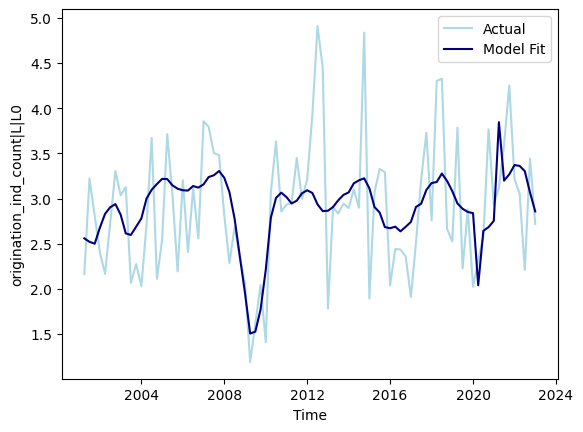

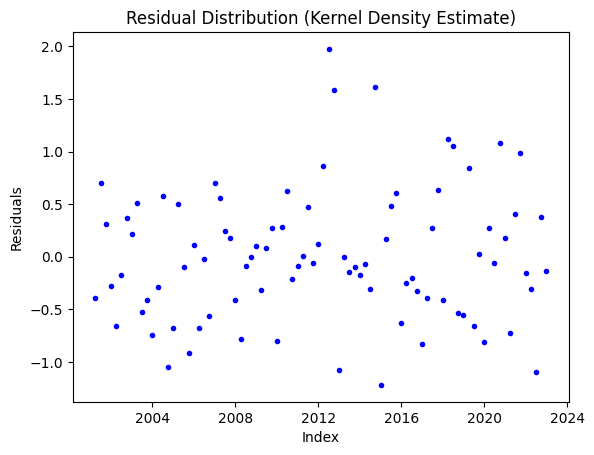

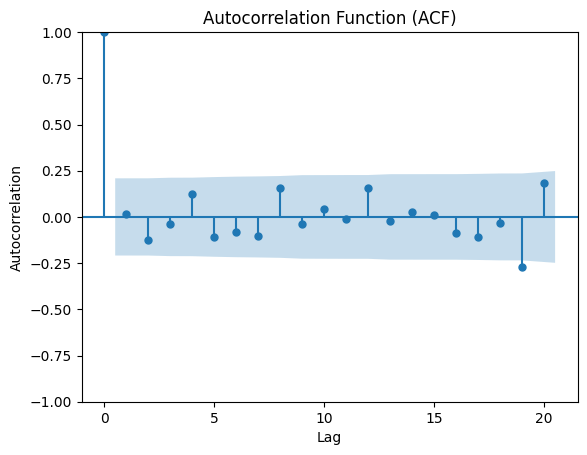

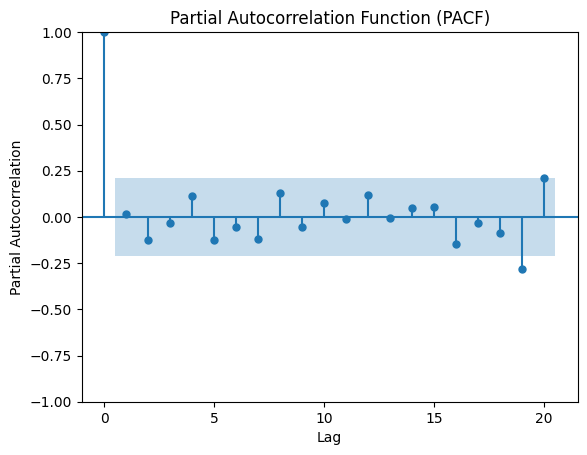

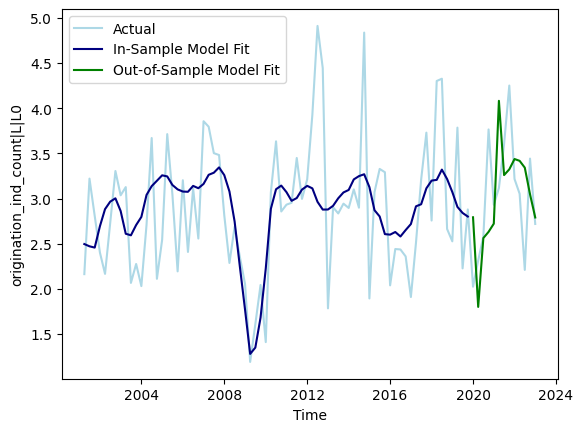

Completed testing for this model


In [9]:
model_results = standalone.standalone_test(
        transformed_data,
        DV,
        IVs,
        cut_off_date=datetime(2019,12,31),
        lags= 4, # The maximum lag included in serial autocorrelation test
        test_ADF= True, # Cointegration ADF
        test_BG= True, # Autocorrelation Breusch-Godfrey
        test_LB= True, # Autocorrelation Ljung-Box
        test_DW= True, # Autocorrelation Durbin-Watson
        test_BP= True, # Heteroscedasticity Breusche-Pagan
        test_white= True, # Heteroscedasticity White's
        test_RR= True, # Linearity Ramsey's RESET
        reset_order=3, # Order used for Ramsey's RESET
        test_SW= True, # Normality Shapiro-Wilk
        test_JB= True, # Normality Jarque-Bera
        test_vif= True, # Multicollinearity VIF
        test_CD= True, # Cooks Distance
        test_oos= True, # Out-of-sample Test
        save_dir = output_path.replace(".xlsx","") # Directory for saving plots
        )

**Export the results as needed.**

In [10]:
with pd.ExcelWriter(output_path, engine='openpyxl', mode='w') as writer:
    transformed_data.to_excel(writer, sheet_name='data', index=True)
    model_results['fitted'].to_excel(writer, sheet_name='model_fit', index=False)
    model_results['model_stats'].to_excel(writer, sheet_name='model_stats', index=False)
    model_results['residuals'].to_excel(writer, sheet_name='residuals', index=True)
    if model_results['ADF'] is not None: model_results['ADF'].to_excel(writer, sheet_name='ADF', index=True)
    if model_results['BG'] is not None: model_results['BG'].to_excel(writer, sheet_name='BG', index=True)
    if model_results['LB'] is not None: model_results['LB'].to_excel(writer, sheet_name='LB', index=True)
    if model_results['DW'] is not None: model_results['DW'].to_excel(writer, sheet_name='DW', index=True)
    if model_results['BP'] is not None: model_results['BP'].to_excel(writer, sheet_name='BP', index=True)
    if model_results['white'] is not None: model_results['white'].to_excel(writer, sheet_name='white', index=True)
    if model_results['RR'] is not None: model_results['RR'].to_excel(writer, sheet_name='RESET', index=True)
    if model_results['SW'] is not None: model_results['SW'].to_excel(writer, sheet_name='SW', index=False)
    if model_results['JB'] is not None: model_results['JB'].to_excel(writer, sheet_name='JB', index=False)
    if model_results['vif'] is not None: model_results['vif'].to_excel(writer, sheet_name='vif', index=False)
    if model_results['CD'] is not None: model_results['CD'].to_excel(writer, sheet_name='CD', index=True)
    if model_results['oos'] is not None: model_results['oos'].to_excel(writer, sheet_name='OOS', index=True)

# Forecast under different scenarios

## Data Preparation

In [11]:
data_frequency = 4  # 1 if annual, 4 if quarterly, and 12 if monthly
forecast_start_date = datetime(2023,4,1)  # First forecast date 
raw_IVs= ['fedfund_iusa','high_bonds_iusa','indust_prod_iusa'] # These are used for saving the untransformed data

**Transformations**

In [12]:
transformations_input = pd.read_excel(input_path, sheet_name='variable_mapping_table')

## Run Forecast

This section enables you to input scenarios data and predict future DV values using the model developed in the previous section. Additionally, a forecast plot will be generated and saved.

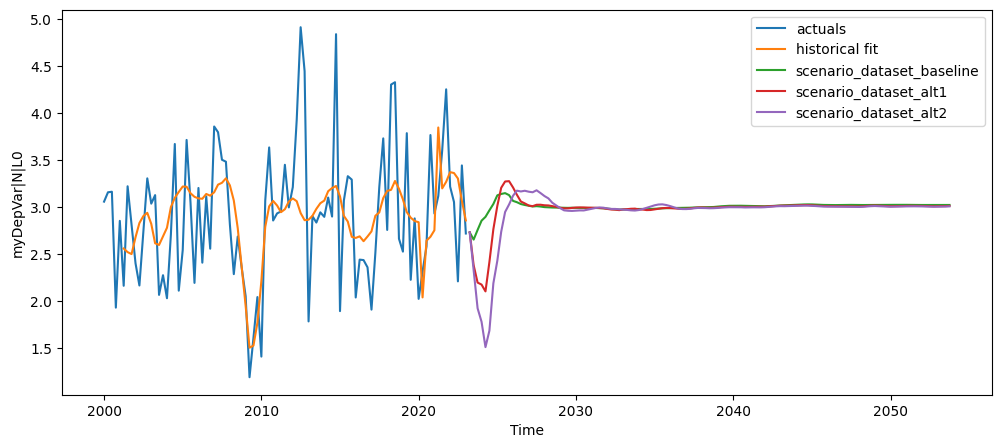

In [13]:
forecast_results, data_overview, ax = standalone.forecast(input_path,
                    DV,
                    IVs,
                    raw_IVs,
                    model_results['model'],
                    transformations_input,
                    forecast_start_date,
                    data_frequency = 4,
                    date_column = "date_quarter", 
                    historical_data = transformed_data, 
                    scenario_sheets=[
                        'scenario_dataset_baseline',
                        'scenario_dataset_alt1',
                        'scenario_dataset_alt2'
                    ],
                    save_dir=output_path.replace(".xlsx",""))

## Save results into Excel file

This saves the results to an Excel with the suffix 'forecast'

In [14]:
with pd.ExcelWriter(output_path.replace(".xlsx", "_forecast.xlsx"), engine='openpyxl', mode='w') as writer:
    
    forecast_results.to_excel(writer,sheet_name='forecast', index=True)
        
    for key, value in data_overview.items():
        value.to_excel(writer, sheet_name=key, index=True)